In [31]:
import pyreadstat
import numpy as np
from prince import MCA
from matplotlib.pyplot import figure
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KDTree

%matplotlib inline

In [2]:
#Load the data
wave1_merge = "/Users/kirill/Downloads/data 2/W1 Merged Data/Wave.1_Data/Merge/Wave1_20170906.sav"
wave2_merge = "/Users/kirill/Downloads/data 2/W2 Merged Data/2w-3rd_release_all/merge/Wave2_20170724.sav"

df1, meta1 = pyreadstat.read_sav(wave1_merge)
df2, meta2 = pyreadstat.read_sav(wave2_merge)
wave1_columns = df1.columns
wave2_columns = df2.columns

In [3]:
#Identify columns with many entries (to check if any are numerical)
for c in df2.columns:
    if len(list(df2[c].unique())) > 14:
        print(c)

idnumber
q20_1
q20_2
q20_3
q39
q54
q91_1
q91_2
q91_3
q100
q101
q102
q160
q161
q162
q163
q164
q165
q166
se3a
se5a
se6
se8a
ir2b
ir9_2
w_all


In [4]:
#Drop columns that have no disambiguation or are not crucial for analysis

df2_trunc = df2.drop(['w_all', 'ir9_2', 'idnumber'], axis=1, inplace=False)
df2_trunc_no_mongol_no_camb = df2_trunc[(df2_trunc['country']!=5) & (df2_trunc['country']!=12)]
# df2_trunc[df2_trunc['q6'].isna()]['country'].hist()
count = 0
silen_countries = {}
cols_to_drop = []
for c in df2_trunc_no_mongol_no_camb.columns:
    if df2_trunc_no_mongol_no_camb[c].isnull().values.any():
        print(c)
        unique_countries = list(df2_trunc_no_mongol_no_camb[df2_trunc_no_mongol_no_camb[c].isna()]['country'].unique())
        cols_to_drop += [c]
        if len(unique_countries) == 1:
            if unique_countries[0] not in silen_countries.keys():
                silen_countries[unique_countries[0]] = 1
            else:
                silen_countries[unique_countries[0]] += 1
        print('\n')
    if not df2_trunc_no_mongol_no_camb[c].isnull().values.any():
        count += 1
print(silen_countries) 
print(count)
df2_trunc_no_nan = df2_trunc_no_mongol_no_camb.drop(cols_to_drop, axis=1, inplace=False)
# df2_trunc = df2_trunc.fillna(-1)

q7


q18


q19


q20_3


q26


q27


q28


q29


q30


q31


q33


q34


q35


q36


q37


q38


q39


q39a


q40


q41


q42


q43


q44


q45


q46


q47


q51_1


q51_2


q51_3


q51_4


q51_5


q51_6


q51_7


q51_8


q51a


q54


q55


q57


q59


q61


q63


q64


q65


q69


q70


q71


q72


q74


q78


q80


q82


q83


q84


q85


q86


q87


q88


q89


q90


q91_1


q91_2


q91_3


q94


q99


q100


q101


q102


q102a


q103


q105


q106


q107


q114


q115


q117


q118


q119_1


q119_2


q119_3


q125


q131


q132


q142


q143


q144


q145


q146


q147


q148


q149


q150


q156


q157


q158


q159


q160


q161


q162


q163


q164


q165


q166


se2


se3a


se5


se5a


se7


se7a


se8a


se8b


se9


se9a


se10a


se10b


se10c


se10d


se10e


se10f


se10g


se10h


se10i


se10j


se10k


se10l


se10m


se10n


se10o


se11


se12a


se12b


ir2


ir2a


ir2b


ir3


ir3a_1


ir3a_2


ir3a_3


ir3a_4


ir3a_5


ir3a_6


ir4


ir5


ir6


ir7


ir8



In [5]:
#Qs to use (wave1, wave2)
#yrsurvey and ir9_3
#q004 and q4 'As for your own family, how do you rate your economic situation today?'
# se002 and se2 gender
# se003a and se3a 'actual age'
# se004 and se4 'marital status'
# se005 and se5 education
# se007 and se7 relgiosity
# se009 and se9 annual income: national quintiles
#se012a and se12a Main Occupation
#q005 and q5 How would you compare the current economic condition of your family with what it was five years ago?
#q006 and q6 What do you think the economic situation of your family will be five years from now?

In [6]:
meta1.column_names_to_labels

{'country': 'Country',
 'idnumber': 'idnumber',
 'level3': 'urban-rural',
 'yrsurvey': 'survey year',
 'se002': 'gender',
 'se003': 'age group',
 'se003a': 'actual age',
 'se004': 'marital status',
 'se004a': 'Marital Status(Y/N)',
 'se005': 'education',
 'se005a': 'education by year',
 'se005b': 'education(four categories)',
 'se006': 'religion',
 'se007': 'relgiosity',
 'se008a': 'n of household members',
 'se008b': 'household generations',
 'se009': 'annual income: national quintiles',
 'se012a': 'Main Occupation',
 'se012bjp': 'main occupation(orginal)',
 'se012bhk': 'OCCUPATION(original)',
 'se012bkr': 'Occupation(original)',
 'se012bcn': 'OCCUPATION',
 'se012bmo': 'employment',
 'se012bph': 'occupation (verbatim)',
 'se012btw': "(Respondent has a job) What is respondent's current occupation?",
 'se012bth': 'Primary occupation of respondent',
 'se014': 'language',
 'se016': 'ethnicity',
 'se017': 'subjective social status',
 'relig1': 'Religion',
 'fgnum': 'number of formal group'

In [7]:
meta2.column_names_to_labels

{'country': 'Country Code',
 'idnumber': 'Interview Numbers',
 'level3': 'Urban-rural',
 'q1': 'How would you rate the overall economic condition of our country today?',
 'q2': 'How would you describe the change in the economic condition of our country over the last years?',
 'q3': "What do you think will be the state of our country's economic condition a few years from now?",
 'q4': 'As for your own family, how do you rate your economic situation today?',
 'q5': 'How would you compare the current economic condition of your family with what it was a few years ago?',
 'q6': 'What do you think the economic situation of your family will be a few years from now?',
 'q7': 'Trust in Prime Minister or president',
 'q8': 'Trust in the Courts',
 'q9': 'Trust in the national government',
 'q10': 'Trust in Political parties',
 'q11': 'Trust in Parliament',
 'q12': 'Trust in Civil service',
 'q13': 'Trust in the military(or armed forces)',
 'q14': 'Trust in the police',
 'q15': 'Trust in local gov

In [8]:
df2_trunc_no_nan_stringy = df2_trunc_no_nan.astype(str)
mca = MCA(n_components = 2, n_iter = 3, random_state = 101)
mca.fit(df2_trunc_no_nan_stringy)
df2_trunc_mca = mca.transform(df2_trunc_no_nan_stringy)
df2_trunc_mca.head()

,0,1
0,-0.480396,0.417412
1,-0.332044,0.187073
2,-0.373987,0.184262
3,-0.331599,-0.117639
4,-0.488901,0.505283


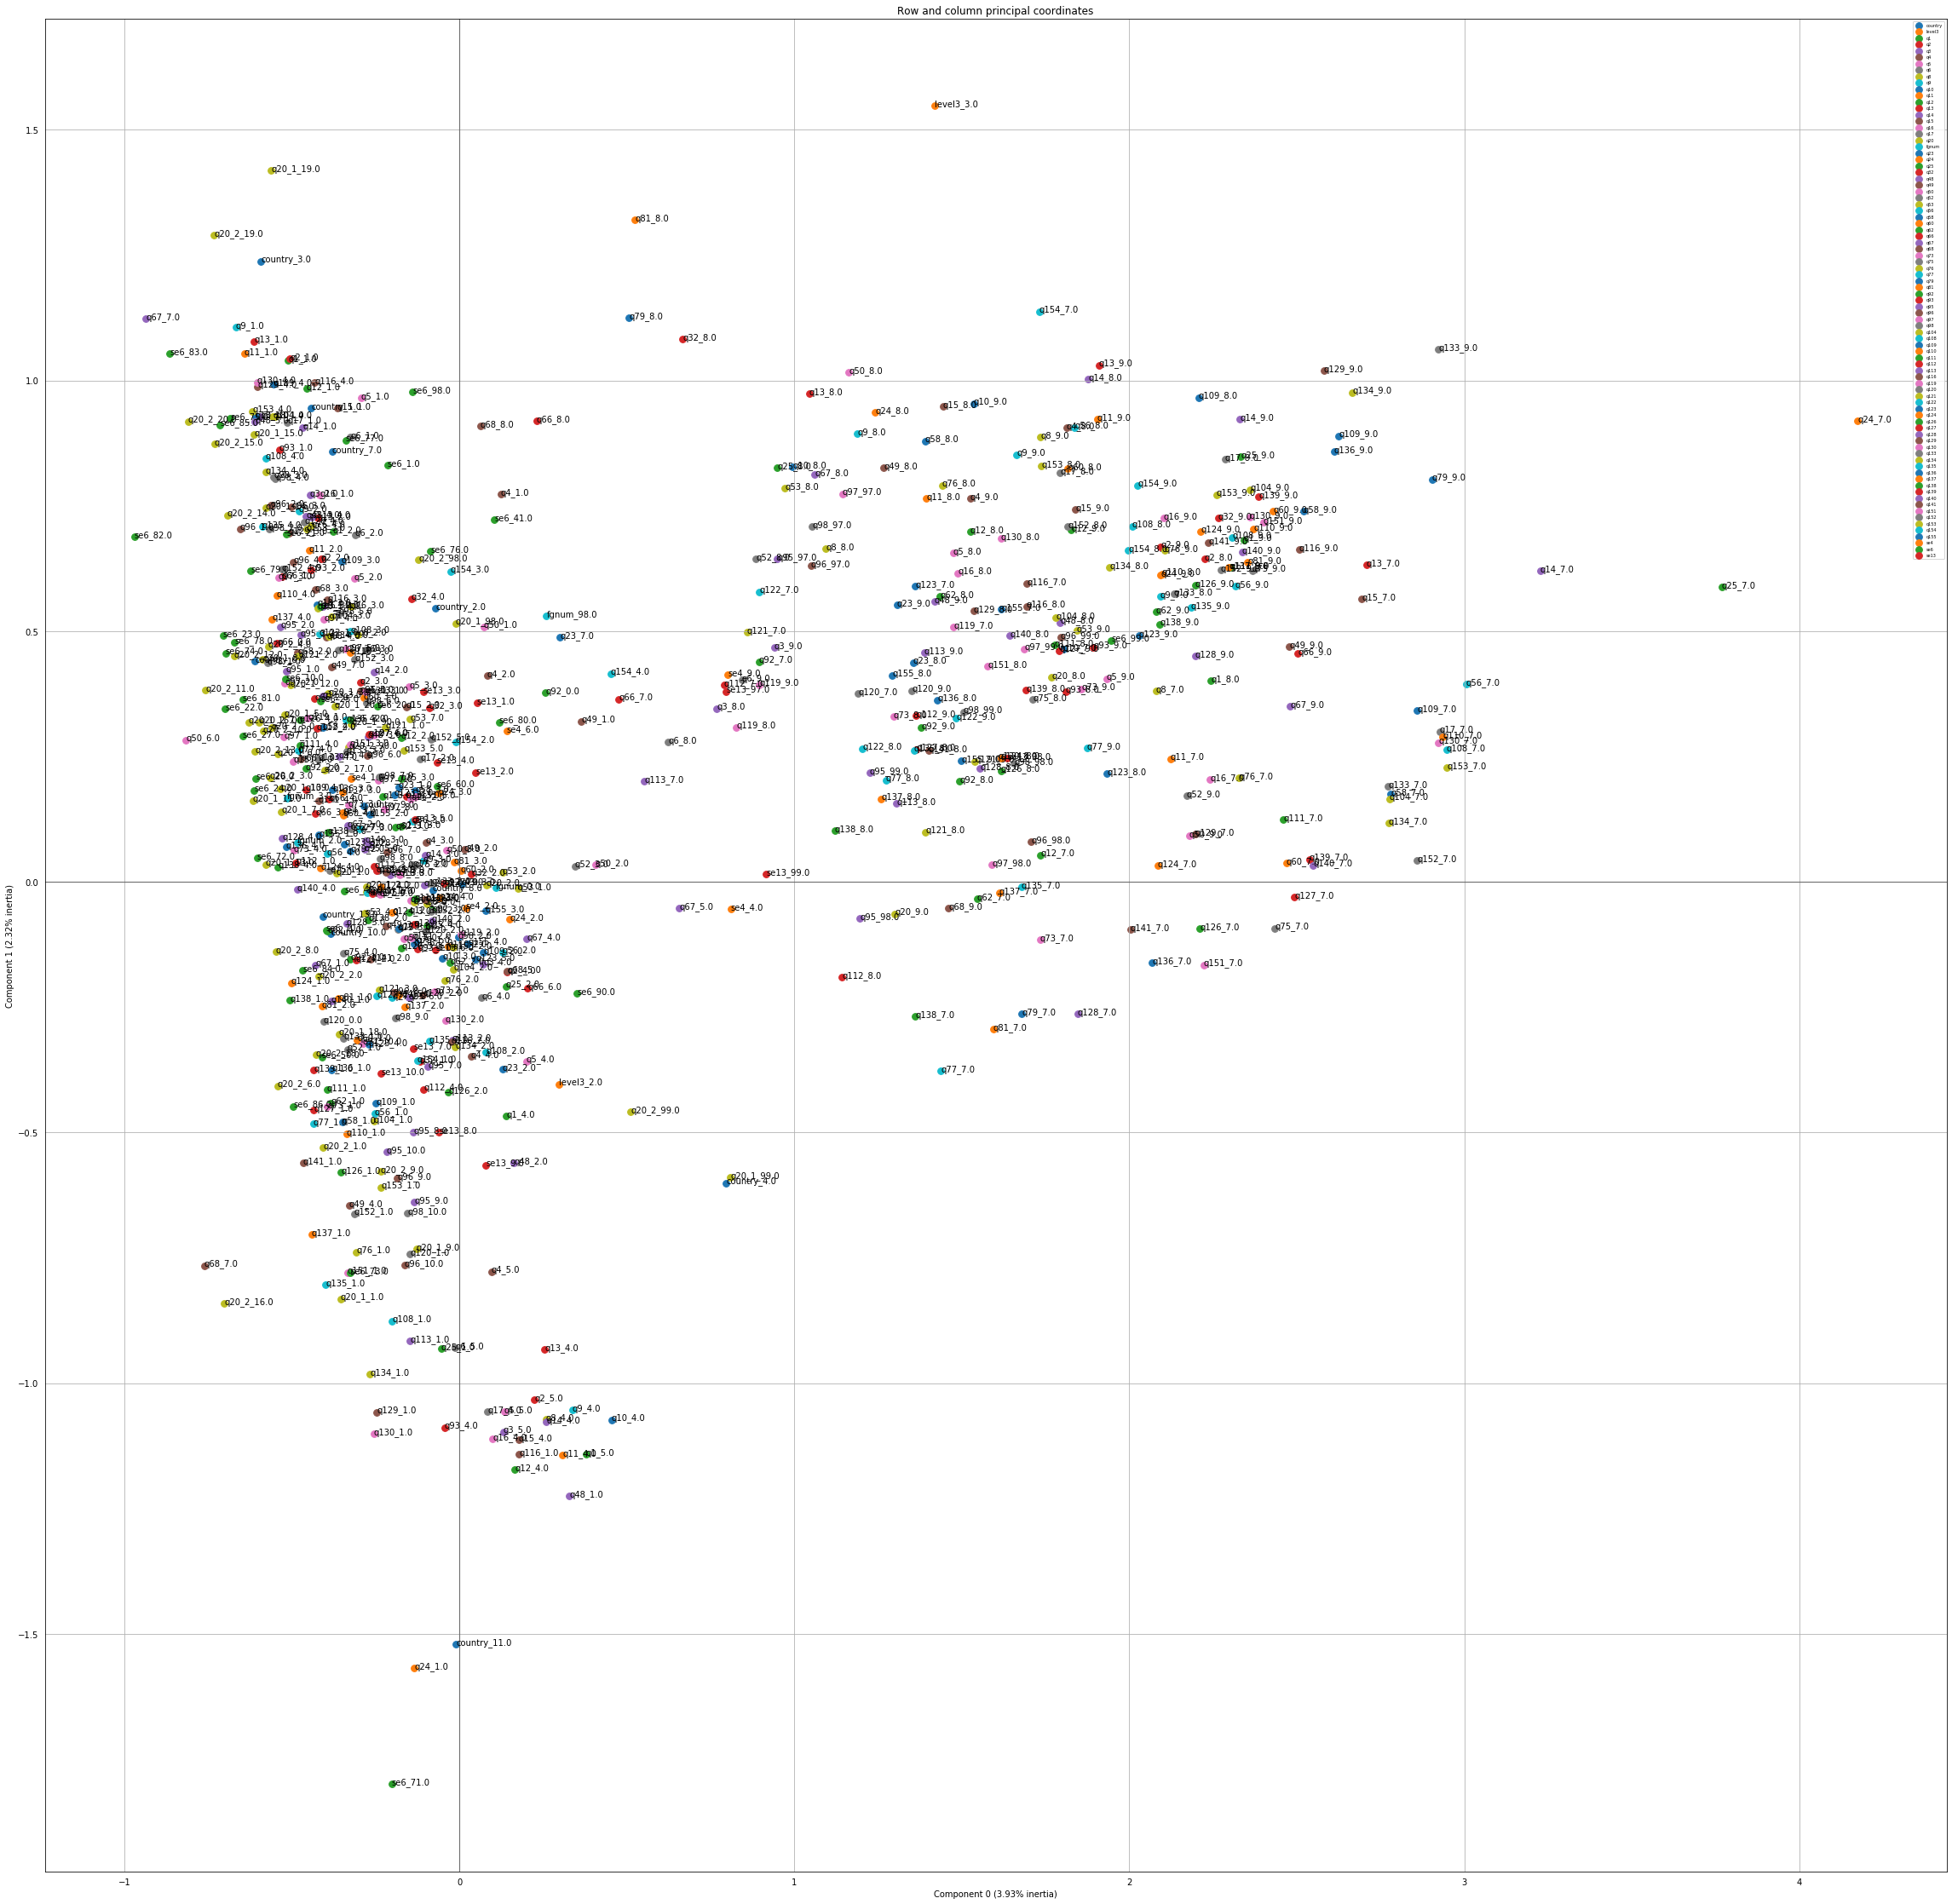

In [17]:
# fig = figure(num=None, figsize=(100, 100), dpi=150, facecolor='w', edgecolor='k')
# plt.rcParams['figure.figsize'] = (100, 100)
# plt.rcParams['figure.dpi'] = 400
ax = mca.plot_coordinates(X=df2_trunc_no_nan_stringy,
    ax=None,
    figsize=(40, 40),
    show_row_points=False,
    show_row_labels=False,
    show_column_points=True,
    column_points_size=60,
    show_column_labels=True)
plt.legend(prop={'size': 5})
plt.savefig("MCA.pdf", format='pdf', bbox_inches='tight')


In [16]:
df2_trunc_mca.shape

(17587, 2)

In [28]:
col_coords = mca.column_coordinates(df2_trunc_no_nan_stringy)
x = col_coords[0]
y = col_coords[1]

prefixes = col_coords.index.str.split('_').map(lambda x: x[0])

plot_coord = pd.DataFrame(columns = ["question", "answer", "x_coord", "y_coord"])
for prefix in prefixes.unique():
    mask = prefixes == prefix
    for i, label in enumerate(col_coords[mask].index):
        to_append = [label.rsplit('_', -1)[0], label.rsplit('_', -1)[1], x[mask][i], y[mask][i]]
        df_length = len(plot_coord)
        plot_coord.loc[df_length] = to_append
#         ax.annotate(, (x[mask][i], y[mask][i]))
plot_coord.head(5)
arr_coords = np.array(plot_coord[['x_coord', 'y_coord']])

In [77]:
tree = KDTree(arr_coords, leaf_size=2) 
clusters = []
for i, point in enumerate(arr_coords):
    ind = tree.query_radius(point.reshape(1, -1), r=0.2)
    for indx in ind:
        q_a = np.array(plot_coord.iloc[indx][["question", "answer"]])
        clusters.append(q_a)
    

In [78]:
clusters

[array([['q20', '1'],
        ['q134', '4.0'],
        ['q108', '4.0'],
        ['q48', '5.0'],
        ['q10', '1.0'],
        ['q3', '1.0'],
        ['q153', '4.0'],
        ['q130', '4.0'],
        ['q129', '4.0'],
        ['q98', '3.0'],
        ['q98', '4.0'],
        ['q93', '1.0'],
        ['q14', '1.0'],
        ['q17', '1.0'],
        ['q104', '4.0'],
        ['q8', '1.0'],
        ['q12', '1.0'],
        ['q109', '4.0'],
        ['q1', '1.0'],
        ['q2', '1.0'],
        ['q3', '2.0'],
        ['q16', '1.0'],
        ['country', '7.0'],
        ['country', '1.0'],
        ['q116', '4.0'],
        ['q15', '1.0'],
        ['se6', '77.0'],
        ['q6', '1.0'],
        ['q5', '1.0']], dtype=object),
 array([['q120', '0.0'],
        ['q81', '2.0'],
        ['q140', '1.0'],
        ['q20', '2'],
        ['q138', '1.0'],
        ['q124', '1.0'],
        ['se6', '84.0'],
        ['q67', '1.0'],
        ['q20', '2'],
        ['q81', '1.0'],
        ['q127', '2.0'],
        ['q92'

In [87]:
for c in clusters:
    if "q66" in np.array(c)[:,0] and c[np.where(np.array(c)[:,0] == "q66")][0][1] == '0.0' and "level3" in np.array(c)[:,0]:
        print(c)
        print('\n')

[['q136' '3.0']
 ['se4' '1.0']
 ['q20' '2']
 ['q98' '1.0']
 ['q66' '0.0']
 ['q151' '4.0']
 ['q20' '1']
 ['q77' '4.0']
 ['q97' '1.0']
 ['q126' '4.0']
 ['q68' '1.0']
 ['q92' '2.0']
 ['q133' '4.0']
 ['q111' '4.0']
 ['q112' '2.0']
 ['q119' '1.0']
 ['q20' '1']
 ['q97' '2.0']
 ['se6' '10.0']
 ['q66' '2.0']
 ['q20' '1']
 ['q95' '2.0']
 ['q95' '1.0']
 ['q68' '2.0']
 ['q121' '2.0']
 ['q122' '1.0']
 ['q95' '3.0']
 ['q20' '2']
 ['q95' '4.0']
 ['q133' '3.0']
 ['q20' '2']
 ['q151' '3.0']
 ['q58' '4.0']
 ['q20' '1']
 ['q135' '3.0']
 ['se6' '42.0']
 ['q20' '1']
 ['se6' '25.0']
 ['q113' '3.0']
 ['q20' '1']
 ['q49' '7.0']
 ['q152' '3.0']
 ['q68' '4.0']
 ['q134' '3.0']
 ['q120' '3.0']
 ['q97' '5.0']
 ['q110' '3.0']
 ['q108' '3.0']
 ['q96' '6.0']
 ['q48' '3.0']
 ['q97' '6.0']
 ['q127' '4.0']
 ['q121' '1.0']
 ['q60' '3.0']
 ['level3' '1.0']
 ['q96' '5.0']
 ['q2' '3.0']
 ['q8' '2.0']
 ['q130' '3.0']
 ['q6' '3.0']
 ['q98' '6.0']
 ['q14' '2.0']
 ['se6' '20.0']
 ['q20' '1']
 ['q3' '3.0']
 ['se6' '30.0']
 ['q1